In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xarray as xr
from ALLCools.plot import *

In [2]:
from matplotlib import rc

labelsize = 6
linewidth = 0.5
rc('lines', linewidth=linewidth)
rc('axes', labelsize=labelsize, linewidth=linewidth)
rc('xtick', labelsize=labelsize)
rc('ytick', labelsize=labelsize)
rc('xtick.major', width=linewidth)
rc('ytick.major', width=linewidth)
rc('xtick.minor', width=linewidth-0.2)
rc('ytick.minor', width=linewidth-0.2)

In [3]:
cell_tidy_data = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ClusteringSummary/Summary/TotalClusteringResults.msg'
)

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


## N reads

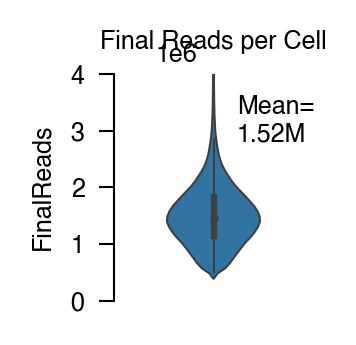

In [4]:
fig, ax = plt.subplots(figsize=(0.5, 1), dpi=300)

sns.violinplot(cell_tidy_data['FinalReads'], orient='v', ax=ax)
ax.set(ylim=(0, 4000000), xticks=[])
ax.ticklabel_format(axis='y', style='sci', scilimits=(1, 2))
sns.despine(ax=ax, offset=10, bottom=True)
ax.text(0.7, 0.7, f"Mean=\n1.52M", fontsize=labelsize, transform=ax.transAxes)

ax.set_title('Final Reads per Cell', fontsize=labelsize)

fig.savefig('files/FianlReads.violin.pdf', bbox_inches='tight')


In [5]:
cell_tidy_data['FinalReads'].describe()

count    1.039820e+05
mean     1.519459e+06
std      5.758405e+05
min      5.000710e+05
25%      1.131826e+06
50%      1.464610e+06
75%      1.820728e+06
max      9.303761e+06
Name: FinalReads, dtype: float64

## Gene %

In [6]:
total_gene_2kb_mcds = xr.open_mfdataset(
    '/home/hanliu/project/mouse_rostral_brain/dataset/gene_with_2kb_slop/*mcds'
)
total_gene_2kb_mcds

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,


<xarray.Dataset>
Dimensions:           (cell: 158926, count_type: 2, geneslop2k: 55487, mc_type: 2, strand_type: 1)
Coordinates:
    geneslop2k_end    (geneslop2k) int64 dask.array<chunksize=(55487,), meta=np.ndarray>
    geneslop2k_chrom  (geneslop2k) object dask.array<chunksize=(55487,), meta=np.ndarray>
    geneslop2k_start  (geneslop2k) int64 dask.array<chunksize=(55487,), meta=np.ndarray>
  * count_type        (count_type) object 'mc' 'cov'
  * strand_type       (strand_type) object 'both'
  * mc_type           (mc_type) object 'CGN' 'CHN'
  * geneslop2k        (geneslop2k) object 'ENSMUSG00000102693.1' ... 'ENSMUSG00000064372.1'
  * cell              (cell) object '10A_M_10' '10A_M_0' ... '9J_M_3036'
Data variables:
    geneslop2k_da     (cell, geneslop2k, mc_type, strand_type, count_type) uint32 dask.array<chunksize=(1510, 55487, 2, 1, 2), meta=np.ndarray>

In [7]:
gene_meta = pd.read_csv(
    '/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz',
    index_col='gene_id',
    sep='\t')
gene_meta.index.name = 'gene'
gene_name_to_id = {v: k for k, v in gene_meta['gene_name'].iteritems()}
gene_idbase_to_id = {i.split('.')[0]: i for i in gene_meta.index}

In [8]:
cell_by_gene = total_gene_2kb_mcds['geneslop2k_da'].sel(
    cell=cell_tidy_data.index, count_type='cov').sum(dim='mc_type').squeeze()
n_gene_detected = (cell_by_gene > 20).sum(dim='geneslop2k') / 55487
genes_detected_rate = n_gene_detected.values


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/xarray/core/indexing.py:1325: PerformanceWarning: Slicing with an out-of-order index is generating 96 times more chunks
  return self.array[key]


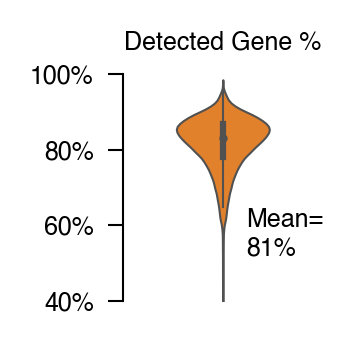

In [10]:
import matplotlib.ticker as mtick


fig, ax = plt.subplots(figsize=(0.5, 1), dpi=300)

sns.violinplot(genes_detected_rate*100, orient='v', ax=ax, color='#FF7F0E')
ax.set(ylim=(40, 100), xticks=[])
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

ax.text(0.7, 0.2, f"Mean=\n81%", fontsize=labelsize, transform=ax.transAxes)
sns.despine(ax=ax, offset=10, bottom=True)
ax.set_title('Detected Gene %', fontsize=labelsize)
fig.savefig('files/GenesDetected.violin.pdf', bbox_inches='tight')


In [11]:
pd.Series(genes_detected_rate * 100).describe(), pd.Series(genes_detected_rate * 100).median()

(count    103982.000000
 mean         81.418615
 std           7.776113
 min          23.719069
 25%          77.940779
 50%          83.060897
 75%          86.658136
 max          96.938022
 dtype: float64, 83.06089714707949)

## Chrom100k %

In [6]:
total_mcds = xr.open_mfdataset(
    '/home/hanliu/project/mouse_rostral_brain/dataset/*.mcds'
)
total_mcds

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,


<xarray.Dataset>
Dimensions:              (cell: 161475, chrom100k: 27269, count_type: 2, gene: 58598, mc_type: 2, strand_type: 1)
Coordinates:
    chrom100k_bin_end    (chrom100k) int64 dask.array<chunksize=(27269,), meta=np.ndarray>
    gene_end             (gene) float64 dask.array<chunksize=(58598,), meta=np.ndarray>
    gene_chrom           (gene) object dask.array<chunksize=(58598,), meta=np.ndarray>
    chrom100k_bin_start  (chrom100k) int64 dask.array<chunksize=(27269,), meta=np.ndarray>
    chrom100k_chrom      (chrom100k) object dask.array<chunksize=(27269,), meta=np.ndarray>
    gene_start           (gene) float64 dask.array<chunksize=(58598,), meta=np.ndarray>
  * gene                 (gene) object 'ENSMUSG00000000001.4' ... 'ENSMUSG00000118488.1'
  * chrom100k            (chrom100k) int64 0 1 2 3 4 ... 27265 27266 27267 27268
  * strand_type          (strand_type) object 'both'
  * mc_type              (mc_type) object 'CGN' 'CHN'
  * count_type           (count_type) object 'mc' 'cov'
  * cell                 (cell) object '10A_M_10' '10A_M_0' ... '9J_M_3032'
Data variables:
    gene_da              (cell, gene, mc_type, strand_type, count_type) float64 dask.array<chunksize=(1510, 58598, 2, 1, 2), meta=np.ndarray>
    chrom100k_da         (cell, chrom100k, mc_type, strand_type, count_type) uint32 dask.array<chunksize=(1510, 27269, 2, 1, 2), meta=np.ndarray>

In [7]:
feature_detect_rate = (total_mcds['chrom100k_da'].sel(count_type='cov', cell=cell_tidy_data.index).sum(
    dim='mc_type').squeeze() > 20).sum(dim='chrom100k') / 27269
feature_detect_rate = feature_detect_rate.values

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/xarray/core/indexing.py:1325: PerformanceWarning: Slicing with an out-of-order index is generating 93 times more chunks
  return self.array[key]


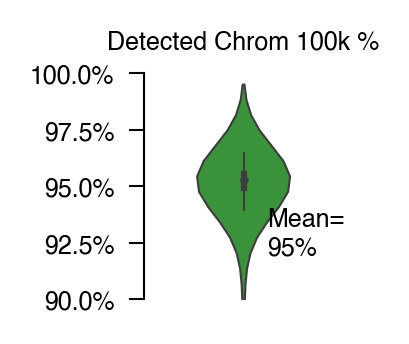

In [21]:
import matplotlib.ticker as mtick


fig, ax = plt.subplots(figsize=(0.5, 1), dpi=300)

sns.violinplot(feature_detect_rate*100, orient='v', ax=ax, color='#2CA02C', bw=0.4, cut=2)
ax.set(ylim=(90, 100), xticks=[])
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

ax.text(0.7, 0.2, f"Mean=\n95%", fontsize=labelsize, transform=ax.transAxes)
sns.despine(ax=ax, offset=10, bottom=True)

ax.set_title('Detected Chrom 100k %', fontsize=labelsize)
fig.savefig('files/Chrom100kDetected.violin.pdf', bbox_inches='tight')


In [20]:
pd.Series(feature_detect_rate).describe()

count    103982.000000
mean          0.945672
std           0.036297
min           0.354358
25%           0.949026
50%           0.952914
75%           0.955334
max           0.965859
dtype: float64

In [10]:
pd.Series(feature_detect_rate).median()

0.9529135648538634